# Final Solution
### Peilin Luo

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from riskill import risk, sim
import datetime

# Q1

In [14]:
df1 = pd.read_csv('problem1.csv')
df1

,Price1,Price2,Price3,Date
0,103.590465,101.766238,113.286263,2023-04-12
1,103.525234,101.674451,112.667758,2023-04-13
2,103.545354,101.696751,112.934738,2023-04-14
3,103.562507,101.528794,111.640170,2023-04-15
4,103.566943,101.783333,113.400133,2023-04-16
5,NaN,101.579592,111.705346,2023-04-17
6,103.574691,101.676779,112.793174,2023-04-18
7,103.585940,101.746275,113.380853,2023-04-19
8,103.545262,101.755857,113.127060,2023-04-20
9,103.601859,101.930429,114.394761,2023-04-21


In [15]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1

,Price1,Price2,Price3,Date
0,103.590465,101.766238,113.286263,2023-04-12
1,103.525234,101.674451,112.667758,2023-04-13
2,103.545354,101.696751,112.934738,2023-04-14
3,103.562507,101.528794,111.640170,2023-04-15
4,103.566943,101.783333,113.400133,2023-04-16
5,NaN,101.579592,111.705346,2023-04-17
6,103.574691,101.676779,112.793174,2023-04-18
7,103.585940,101.746275,113.380853,2023-04-19
8,103.545262,101.755857,113.127060,2023-04-20
9,103.601859,101.930429,114.394761,2023-04-21


In [16]:
df1.dtypes

Price1           float64
Price2           float64
Price3           float64
Date      datetime64[ns]
dtype: object

In [18]:
def return_calculate(prices: pd.DataFrame, method: str = 'DISCRETE', date_column: str = 'Date') \
        -> pd.DataFrame:
    Vars = prices.columns.drop(date_column)
    n_vars = prices.shape[1]
    if n_vars == Vars.size:
        raise ValueError("date column: " + date_column + " not in DataFrame")
    n_vars -= 1

    p = prices[Vars]
    out = (p / p.shift(1))

    if method.upper() == "DISCRETE":
        out = out.apply(lambda x: x-1)
    elif method.upper() == "LOG":
        out = out.apply(np.log)
    else:
        raise ValueError("method: " + method + " must be 'LOG' or 'DISCRETE'")

    out.index = prices[date_column]
    return out

In [22]:
# log return
returns = return_calculate(df1, 'log').iloc[1:, :]
returns

,Price1,Price2,Price3
Date,,,
2023-04-13,-0.000630,-0.000902,-0.005475
2023-04-14,0.000194,0.000219,0.002367
2023-04-15,0.000166,-0.001653,-0.011529
2023-04-16,0.000043,0.002504,0.015642
2023-04-17,NaN,-0.002004,-0.015058
2023-04-18,NaN,0.000956,0.009691
2023-04-19,0.000109,0.000683,0.005197
2023-04-20,-0.000393,0.000094,-0.002241
2023-04-21,0.000546,0.001714,0.011144


In [23]:
# pairwise
from riskill import covmatrix

pairwise = covmatrix.missing_cov(returns, False)
pairwise

,Price1,Price2,Price3
Price1,2.221428e-07,6.380692e-07,0.000003
Price2,6.380692e-07,3.327751e-06,0.000020
Price3,3.453138e-06,2.019423e-05,0.000120


In [25]:
evals = np.linalg.eigh(pairwise)[0]
evals # not psd

array([-7.36686137e-08,  1.39998018e-07,  1.23940569e-04])

In [28]:
from riskill import to_psd

fixed = to_psd.near_psd(np.array(pairwise))
fixed

array([[2.22142805e-07, 6.34731184e-07, 3.44701887e-06],
       [6.34731184e-07, 3.32775072e-06, 1.99189511e-05],
       [3.44701887e-06, 1.99189511e-05, 1.20457005e-04]])

In [29]:
np.linalg.eigh(fixed)[0] # psd

array([5.46035423e-21, 1.55827033e-07, 1.23851072e-04])

# Q2

In [35]:
df2 = pd.read_csv('problem2.csv')
df2

,Underlying,Strike,IV,TTM,RF,DivRate
0,119.384857,115.303776,0.23,148,0.045,0.044748


In [36]:
underlying = df2['Underlying'][0]
strike = df2['Strike'][0]
rf = df2['RF'][0]
divRate = df2['DivRate'][0]
ttm = df2['TTM'][0]/255
b = rf - divRate
ivol = df2['IV'][0]

In [44]:
ivol, ivol/np.sqrt(255)

(0.23, 0.014403158694958439)

In [37]:
from riskill import option

call = option.gbsm(True, underlying, strike, ttm, rf, b, ivol)
call

10.135752305582585

In [38]:
g = option.Greeks(True, underlying, strike, ttm, rf, b, ivol)
g.delta(), g.gamma(), g.vega(), g.rho()

(0.5972102882454573,
 0.017832538296421258,
 33.92821604837931,
 35.49801049609497)

In [40]:
# share-call portfolio
currentValue = underlying-call
currentValue

109.24910490130002

In [45]:
simReturns = sps.norm.rvs(size=25000, scale=ivol/np.sqrt(255))
simReturns

array([ 0.01160374, -0.00629451, -0.00374916, ...,  0.00116251,
        0.00939606,  0.00615832])

In [83]:
simPrices = underlying*(1+simReturns)
simPrices

array([120.77016837, 118.63338801, 118.93726374, ..., 119.52364359,
       120.50660397, 120.12006782])

In [84]:
[option.gbsm(True, x, strike, ttm, rf, b, ivol) for x in simPrices]

[10.980006641040987,
 9.692029718547374,
 9.870237005881812,
 9.04596174801803,
 12.462823711360357,
 11.101597202052318,
 11.499543042273928,
 10.044277404999143,
 8.69052654317774,
 9.596983052769076,
 10.29563852889062,
 8.70479100813845,
 9.331028239921984,
 9.37368964184072,
 10.600677926700286,
 9.843210098950593,
 9.91428436329764,
 10.100347124951234,
 8.98203907163365,
 8.539619605472907,
 10.653799483640078,
 8.823870640984929,
 9.710649067456075,
 11.042393197144591,
 8.689336456308318,
 9.536937719381022,
 8.426948862570477,
 12.157235282434428,
 8.692905792848862,
 12.972038363219184,
 9.269019423550596,
 11.418490544648293,
 9.91249101011904,
 10.154223992134519,
 11.199865200643302,
 9.538109701209699,
 9.178947018431721,
 10.78312437529248,
 13.400176525507263,
 11.707645576108177,
 10.22360692195965,
 12.213890777797914,
 10.312808837552502,
 8.189905873788724,
 10.030417472948379,
 9.956031093216708,
 7.910135366831298,
 11.294636076514976,
 10.005679859222631,
 9.546

In [85]:
simValues = simPrices - np.array([option.gbsm(True, x, strike, ttm, rf, b, ivol) for x in simPrices])
simValues

array([109.79016173, 108.94135829, 109.06702673, ..., 109.30483506,
       109.68980801, 109.54044706])

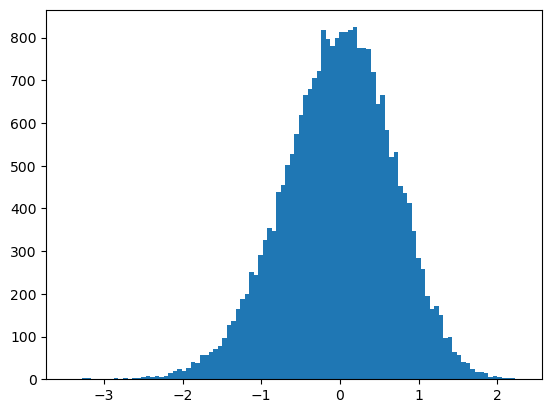

In [86]:
pnl = simValues - currentValue
plt.hist(pnl, bins=100);

In [87]:
pnl.mean(), pnl.std(), sps.skew(pnl), sps.kurtosis(pnl)

(-0.024132621461494745,
 0.6980831153383729,
 -0.24164728827486529,
 0.09920145274993342)

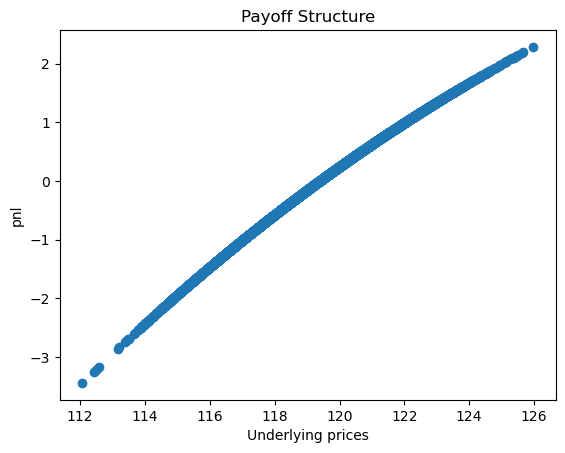

In [90]:
plt.scatter(simPrices, pnl)
plt.xlabel('Underlying prices')
plt.ylabel('pnl')
plt.title('Payoff Structure')
plt.show()

C:\Users\peili\anaconda3\lib\site-packages\riskill\option.py:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(underlying/strike) + (b + ivol**2 / 2) * ttm) / (ivol * np.sqrt(ttm))


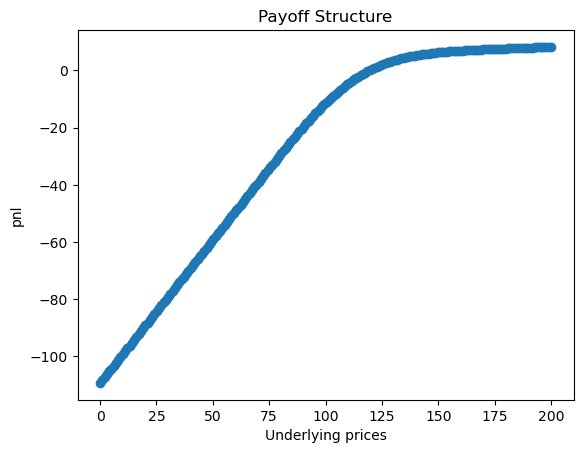

In [92]:
newValues = np.linspace(0, 200, 200) - np.array([option.gbsm(True, x, strike, ttm, rf, b, ivol) for x in np.linspace(0, 200, 200)])
newpnl = newValues - currentValue
plt.scatter(np.linspace(0, 200, 200), newpnl)
plt.xlabel('Underlying prices')
plt.ylabel('pnl')
plt.title('Payoff Structure')
plt.show()

In [88]:
VAR, ES = risk.VaR_ES(pnl)
VAR, ES

(1.2169104950617253, 1.5554911685447408)

# Q3

In [56]:
df3_cov = pd.read_csv('problem3_cov.csv')
df3_cov

,Asset1,Asset2,Asset3
0,0.045346,0.011685,0.011787
1,0.011685,0.033457,0.010124
2,0.011787,0.010124,0.034042


In [57]:
covar = np.array(df3_cov)
covar

array([[0.04534633, 0.01168526, 0.01178684],
       [0.01168526, 0.03345739, 0.01012447],
       [0.01178684, 0.01012447, 0.03404163]])

In [58]:
df3_er = pd.read_csv('problem3_ER.csv')
df3_er

,RF,Expected_Value_1,Expected_Value_2,Expected_Value_3
0,0.045,0.130479,0.118423,0.119061


In [63]:
StockMeans = np.array(df3_er.iloc[:, 1:]).reshape(-1)
StockMeans

array([0.13047853, 0.11842298, 0.11906127])

In [64]:
rf = df3_er['RF'][0]
rf

0.045

In [65]:
from riskill import portfolio

Optimal_w = portfolio.optimize_sharpe(StockMeans, covar, rf)
Optimal_w

array([0.30122282, 0.35076993, 0.34800725])

In [66]:
RP_w = portfolio.risk_parity(covar)
RP_w

array([0.30135442, 0.35083461, 0.34781097])

In [67]:
er_op = StockMeans@Optimal_w
var_op = Optimal_w@covar@Optimal_w
sr_op = (er_op - rf)/var_op
er_op, var_op, sr_op

(0.12227651727576867, 0.01976613868611707, 3.909540376241747)

In [68]:
er_rp = StockMeans@RP_w
var_rp = RP_w@covar@RP_w
sr_rp = (er_rp - rf)/var_rp
er_rp, var_rp, sr_rp

(0.12227797853144334, 0.019766884664865637, 3.9094667592612593)

In [156]:
var = np.diagonal(covar)
var

array([0.04534633, 0.03345739, 0.03404163])

In [159]:
srs = (StockMeans-rf)/var
srs

array([1.88501561, 2.19452222, 2.17560907])

# Q4

In [70]:
df4_ret = pd.read_csv('problem4_returns.csv')
df4_ret['Date'] = pd.to_datetime(df4_ret['Date'])
df4_ret.set_index('Date', inplace=True)
df4_ret

,Asset1,Asset2,Asset3
Date,,,
2023-04-12,0.043243,-0.045297,0.041501
2023-04-13,0.041187,0.020814,-0.007092
2023-04-14,-0.078281,-0.061686,-0.079917
2023-04-15,-0.043627,0.077052,-0.036831
2023-04-16,-0.026264,-0.032431,0.018789
2023-04-17,0.026626,-0.014197,0.050270
2023-04-18,0.089793,-0.037203,-0.047966
2023-04-19,-0.110389,-0.025194,0.029899
2023-04-20,-0.042698,0.031882,0.025596


In [75]:
stocks = list(df4_ret.columns)

In [76]:
df4_w = pd.read_csv('problem4_startWeight.csv')
weight = np.array(df4_w).reshape(-1)
weight

array([0.49095219, 0.08270424, 0.42634357])

In [78]:
portfolio.weights_through_time(df4_ret, stocks, weight)[0]

array([[0.49095219, 0.08270424, 0.42634357],
       [0.49477729, 0.07627482, 0.42894789],
       [0.50558816, 0.07641628, 0.41799555],
       [0.5052679 , 0.07774282, 0.41698928],
       [0.49889555, 0.08644846, 0.41465599],
       [0.48976719, 0.08432927, 0.42590354],
       [0.48662565, 0.08045657, 0.43291778],
       [0.51995481, 0.07594914, 0.40409605],
       [0.48548629, 0.07770562, 0.43680808],
       [0.46806701, 0.08075406, 0.45117893],
       [0.43586661, 0.08753162, 0.47660177],
       [0.44971475, 0.08822193, 0.46206332],
       [0.46123721, 0.09219611, 0.44656667],
       [0.45417373, 0.08660202, 0.45922425],
       [0.44634918, 0.0805715 , 0.47307931],
       [0.45162549, 0.07522385, 0.47315066],
       [0.49643623, 0.06759243, 0.43597134],
       [0.49487383, 0.07109828, 0.43402789],
       [0.47467397, 0.07574573, 0.4495803 ],
       [0.50167547, 0.07050505, 0.42781948]])

In [80]:
result = portfolio.ex_post_attribution(df4_ret, stocks, weight)
result

,Asset1,Asset2,Asset3,Portfolio
TotalReturn,0.080428,-0.062929,-0.037279,0.018388
Return Attribution,0.037525,-0.005434,-0.013702,0.018388
Vol Attribution,0.026484,0.000376,0.007973,0.034832


In [82]:
result.loc['Vol Attribution'].iloc[:3].sum()

0.03483222335881697

# Q5

In [145]:
df5 = pd.read_csv('problem5.csv')
df5['Date'] = pd.to_datetime(df5['Date'])
df5

,Price1,Price2,Price3,Price4,Date
0,112.960391,103.263730,102.044973,89.650730,2023-03-02
1,113.004765,103.279300,102.078021,89.696421,2023-03-03
2,112.964249,103.275383,102.056181,89.680442,2023-03-04
3,113.000871,103.315856,102.071544,89.697272,2023-03-05
4,113.004939,103.305299,102.069408,89.695816,2023-03-06
...,...,...,...,...,...
56,112.980387,103.291511,102.107227,89.703337,2023-04-27
57,112.974294,103.284548,102.038370,89.674655,2023-04-28
58,113.025995,103.301690,102.068575,89.688160,2023-04-29
59,112.960771,103.297609,102.059072,89.677769,2023-04-30


In [146]:
returns = risk.return_calculate(df5)
returns

,Price1,Price2,Price3,Price4
Date,,,,
2023-03-03,0.000393,0.000151,0.000324,0.000510
2023-03-04,-0.000359,-0.000038,-0.000214,-0.000178
2023-03-05,0.000324,0.000392,0.000151,0.000188
2023-03-06,0.000036,-0.000102,-0.000021,-0.000016
2023-03-07,0.000190,-0.000255,-0.000052,-0.000344
2023-03-08,-0.000574,-0.000177,0.000187,0.000086
2023-03-09,0.000493,0.000820,0.000132,0.000631
2023-03-10,0.000131,-0.000074,0.000147,-0.000011
2023-03-11,-0.000217,-0.000339,-0.000119,-0.000199


In [147]:
nms = list(returns.columns)
nms

['Price1', 'Price2', 'Price3', 'Price4']

In [148]:
# VaR for each asset
for nm in nms:
    VaR1 = risk.ByDistri().VaR_t(returns[nm])
    print("For ", nm)
    print("VaR is {}%".format(round(VaR1*100, 6)))

For  Price1
VaR is 0.087302%
For  Price2
VaR is 0.056428%
For  Price3
VaR is 0.05171%
For  Price4
VaR is 0.068144%


In [149]:
{nms[0]: 1, nms[1]: 1}

{'Price1': 1, 'Price2': 1}

In [150]:
class PCA:
    @staticmethod
    def conduct_pca(mat: np.ndarray) -> (np.ndarray, np.ndarray, list):
        eigenvalues, eigenvectors = np.linalg.eigh(mat)
        e_vals_sort = np.flip(np.real(eigenvalues), axis=0)
        pos_e_vals = e_vals_sort[e_vals_sort >= 1e-8]
        pos_e_vecs = np.flip(np.real(eigenvectors), axis=1)[:, : pos_e_vals.size]
        cum_explain = [pos_e_vals[:i+1].sum() / pos_e_vals.sum() for i in range(pos_e_vals.size)]
        return pos_e_vals, pos_e_vecs, cum_explain

    def simulation(self, mat: np.ndarray, draw: int = 25000, min_explain: float = 1.0):
        pca = self.conduct_pca(mat)
        pca_vals = pca[0]
        pca_vecs = pca[1]
        for i, cum in enumerate(pca[2]):
            if cum >= min_explain:
                pca_vals = pca_vals[: i + 1]
                pca_vecs = pca_vecs[:, : i + 1]
        B = pca_vecs @ np.diag(np.sqrt(pca_vals))
        r = np.random.standard_normal((B.shape[1], draw))
        X = (B @ r).T
        return X

In [151]:
def simulation_multi_t(mat: pd.DataFrame, draw: int = 25000, min_explain: float = 1.0) -> dict:
    U = mat.copy()
    frees = []
    mus = []
    sigmas = []

    # transform with CDF to conduct simulation
    for col in mat.columns:
        free, mu, sigma = sps.t.fit(mat[col])
        U[col] = mat[col].apply(lambda x: sps.t.cdf(x, free, mu, sigma))
        frees.append(free)
        mus.append(mu)
        sigmas.append(sigma)

    cor = sps.spearmanr(U)[0]
    if cor.size == 1:
        cormat = np.array([[1.0, cor],
                           [cor, 1.0]])
    else:
        cormat = cor
    N = PCA().simulation(cormat, draw, min_explain)

    # transform back
    U_sim = sps.norm.cdf(N)
    X = U_sim.copy()
    for i in range(U_sim.shape[1]):
        X[:, i] = sps.t.ppf(U_sim[:, i], frees[i], loc=mus[i], scale=sigmas[i])

    dic = {'X': X, 'dfs': frees, 'mus': mus, 'sigmas': sigmas}

    return dic

In [152]:
def portfolio_VaR_ES_t(prices: pd.DataFrame, P: dict, alpha: float = 0.05,
                       return_method: str = 'DISCRETE', date_column: str = 'Date') -> (float, float):
    """
    in dollar
    """
    prices_P = prices[[date_column] + list(P.keys())]
    holdings = np.array(list(P.values()))
    current_value_P = holdings.T @ prices_P.iloc[-1, 1:]
    returns_P = (return_calculate(prices_P, return_method)).dropna()
    sim_returns = simulation_multi_t(returns_P)['X']

    if return_method.upper() == 'DISCRETE':
        sim_prices = (sim_returns + 1) * np.array(prices_P.iloc[-1, 1:])
    elif return_method.upper() == 'LOG':
        sim_prices = np.exp(sim_returns) * np.array(prices_P.iloc[-1, 1:])
    else:
        raise ValueError("method: " + return_method + " must be 'LOG' or 'DISCRETE'")

    sim_value_P = (sim_prices * holdings).sum(axis=1)
    return risk.VaR_ES(sim_value_P - current_value_P, alpha)

In [153]:
# VaR for 1&2, 3&4
P = {nms[0]: 1, nms[1]: 1}
# VaR2 = risk.ByDistri().portfolio_VaR_ES_t(df5, P)
VaR2 = portfolio_VaR_ES_t(df5, P)[0]
print("For asset1&2")
print("VaR is {}%".format(round(VaR2*100, 6)))
P = {nms[2]: 1, nms[3]: 1}
# VaR2 = risk.ByDistri().portfolio_VaR_ES_t(df5, P)
VaR2 = portfolio_VaR_ES_t(df5, P)[0]
print("For asset3&4")
print("VaR is {}%".format(round(VaR2*100, 6)))

For asset1&2
VaR is 14.500869%
For asset3&4
VaR is 11.027066%


In [154]:
# VaR for all
P = dict(zip(nms, np.ones(4)))
P

{'Price1': 1.0, 'Price2': 1.0, 'Price3': 1.0, 'Price4': 1.0}

In [155]:
VaR3 = portfolio_VaR_ES_t(df5, P)[0]
print("For all assets")
print("VaR is {}%".format(round(VaR3*100, 6)))

For all assets
VaR is 24.249952%
